# CSE204 Project, Reinforcement learning with Flappy Bird

<img src="https://raw.githubusercontent.com/adimajo/polytechnique-cse204-2019-releases/master/logo.jpg" style="float: left; width: 20%" />



### Guruprerana Shabadi & Luca Bonengel, BX22

In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In this project, we studied two different machine learning algorithms to learn how to play the (in)famous game Flappy Bird, **Neuroevolution** and **Q-Learning**.

**Neuroevolution** is a machine learning technique that applies evolutionary algorithms to construct artificial neural networks, taking inspiration from the evolution of biological nervous systems in nature.

**Q-learning** is a model-free reinforcement learning algorithm to learn the value of an action in a particular state.

# I. The game of Flappy Bird

The (in)famous game of flappy consists in controlling a bird and attempting to fly between columns of green pipes without hitting them.

<img src="img/fp.png" width="400">


At each state, the bird can take two actions, either jump or do nothing and continue to fall.

# II. Q-Learning

**Q-learning** is a model-free reinforcement learning algorithm that seeks to find the best possible action to take given a specific state. More specifically, Q-learning seeks to learn a policy that maximizes the total reward. The Q-learning algorithm consists in building a matrix (the Q-matrix) which has a value associated to each `(state, action)` pair. The algorithm itself does not require any further information about the environment that it is working in, and for any finite Markov decision process (MDP), it finds the optimal set of actions or path to take in order to maximize the reward. The Q-matrix is gradually built up and the convergence of the algorithm was shown by [Watkins and Dayan in 1992](http://www.gatsby.ucl.ac.uk/~dayan/papers/wd92.html). 

The Q-learning algorithm gradually builds up the Q-matrix at each iteration, updating one value of the matrix at each step. In our case, let us see how the updates would take place. The model we use for Flappy Bird here was inspired by [Moritz Ebeling-Rump, Manfred Kao, Zachary Hervieux-Moore](http://kilyos.ee.bilkent.edu.tr/~eee546/FlappyQ.pdf). We use the following notations:

- $t$ denotes the $t$-th instance or the time in the game Flappy bird
- $s_t$ denotes the state the bird experiences at the time $t$. We explore further on later the different compositions which we can use to represent the state.
- $\mathscr{A} = \{ \text{flap}, \text{no-flap} \}$ represents the set of actions that the bird can take at each instance of the game. We only have 2 actions in our case.
- $a_t$ represents the action taken by the bird at time $t$. 
- $Q_t(s, a)$ represents the value of the Q matrix at a given state and action at the time $t$. It is initially set to be zero everywhere.
- $R(s_t)$ represents the reward function at the time $t$. The reward depends on the state and is given by,

$$R(s_t) = \begin{cases}0, & \text{if bird is alive} \\ -1000 & \text{if bird is dead} \end{cases}$$

- $\alpha$ represents the learning rate, which in our case is fixed. 
- $\gamma = 1$ is the discount factor which we just set to $1$ because we do not really use this feature of Q-learning because we want that at each iteration the reward (or punishment) is the same as at any other state. We choose this approach because the characteristics in the game do not change, i.e, it does not become more difficult with time. The discount factor would be used to prioritise short term rewards but we do not need this.

At each iteration or instant, the updation of the Q matrix takes place with the following equation. Note that only one term is updated at a given instant and we require to have knowledge of the current state $s_t$ and the next state $s_{t+1}$ after taking the action $a_t$.

$$ Q_{t+1}(s_t, a_t) \leftarrow Q_t(s_t, a_t) + \alpha \left[R(s_{t+1}) + \gamma \max_{a \in \mathscr{A}} Q_t(s_{t+1}, a) - Q_t(s_t, a_t)\right]$$

### a. The set of states $\mathscr{S}$

With our implementation, we use many different inputs from the game as the state variables, for example, the $y$-coordinate of the bird, the $y$-coordinate of the next obstacle, the distance to the next obstacle, whether the bird is alive or not etc. and different combinations of this. However, after trying many different input parameters, we found that just three inputs: the $y$-coordinate of the bird, the $y$-coordinate of the next obstacle and whether the bird is alive or not achieved the best results 

Since our 2D environment is of size $500 \times 500$, with these three inputs, our state can be represented as

$$\mathscr{S} = [0, 500] \times [0, 500] \times \{\text{alive}, \text{not alive}\}$$

Along with the actions, our Q matrix would have the shape,

$$ \text{shape}(Q) = \text{shape}(\mathscr{S} \times \mathscr{A}) = 500 \times 500 \times 2 \times 2$$

which is a very big matrix to fill in and handle. It would take too long for the learning to take place and the matrix to be filled in. This is where we were inspired by [Cihan Ceyhan](https://github.com/chncyhn/flappybird-qlearning-bot) who reduced the state space by **breaking up the grid into blocks** (which we call **discretization**). Although his game had a different implementation, we found that by breaking up the game grid into blocks of $30 \times 30$, we were able to achieve faster and greater results.

With this optimization, our Q-matrix (whose implementation can be found [here](https://github.com/lucabonengel/FlappyProject/blob/main/LearningFlappy/src/q-learning.js)) now has a smaller shape of $30 \times 30 \times 2 \times 2$. However, that since we are dealing with a possibly sparse matrix, we use a JavaScript object to store the matrix values indexed by strings of inputs. This also helps us because we not have to change the matrix implementation whatsoever, each time we want to test the algorithm with different inputs.

### b. Restoring state while training

The pseudocode for the training algorithm which we used initially was:

```
initialize Q-Matrix

while True:
    Use Q-matrix to determine next action
    Take action
    Update state
    Update Q-matrix
    
    if bird dies:
        restart the game
```

We observed that we required about 10 million iterations/updates in order to reach a very well trained algorithm which could reach very high scores (a bird which never dies).

Then, after looking at the idea of [kyokin78](https://github.com/kyokin78/rl-flappybird), we explored a similar approach and observed much better results by moving back the game by $70$ instances and continue training in the same game each time that the bird dies. The pseudocode for the training now looks like:

```
initialize Q-Matrix

while True:
    Use Q-matrix to determine next action
    Take action
    Update state
    Update Q-matrix
    
    if bird dies:
        rewind the game by 70 instances
```

By doing this, we ensure that the situation in which the bird dies is dealt with by allowing it to perfect each obstacle at a time. When we restart the game from the beginning, it might take a long time to reach this state again which is unfavourable. We plot the following graph which clearly shows the superiority of training with state restoring enabled.

In [9]:
f = open("./LearningFlappy/q-learning-data.json", "r")
dataQ = json.loads(f.read())

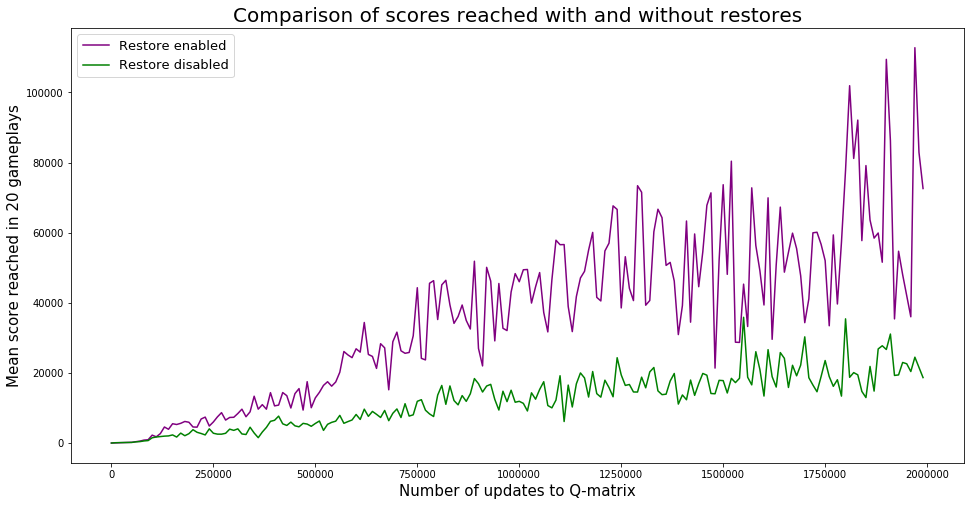

In [10]:
restore_data, no_restore_data = dataQ[0]["restore"], dataQ[0]["noRestore"]
x = [10000*i for i in range(200)]
fig = plt.figure(figsize=(16,8))
plt.plot(x, [np.mean(np.array(arr)) for arr in restore_data], label="Restore enabled", color="purple")
plt.plot(x, [np.mean(np.array(arr)) for arr in no_restore_data], label="Restore disabled", color="green")
plt.legend(fontsize=13)
plt.xlabel("Number of updates to Q-matrix", fontsize=15)
plt.ylabel("Mean score reached in 20 gameplays", fontsize=15)
plt.title("Comparison of scores reached with and without restores", fontsize=20)
plt.show()

### c. Final results

With the optimal parameters mentioned above and training with state restoration enabled, we train the model (update the Q-matrix) over 1 million updates and then run the game to see the scores we can achieve. 

We observe that after **1 million updates** to the Q matrix, we are able to achieve **very high scores of above 100,000 easily**. After more training of upto 10 million updates, we reach a *perfect bird which never dies*. This however, can take a lot of time to achieve, which is approximately 5-10 minutes on our computers.

### d. Determining the optimal parameters

We graph our results with different parameters in order to determine their optimal values. Firstly, with the discretization factor (number of blocks we break the grid into), when we vary its value between 10 (very big blocks) to 500 (no blocking involved since our grid is of size $500 \times 500$). For each discretization factor, we first train the bird for 1 million updates and then take the mean score of it over 20 gameplays.

We observe that the **optimal discretization factor is around 30.** This graph also reminds us of the **bias-variance** trade-off.

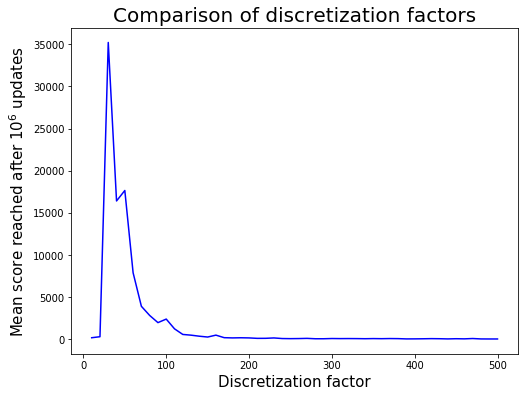

In [11]:
discretization_factors = dataQ[1]["discretizationFactors"]
x = []
y = []
for factor in discretization_factors:
    x.append(int(factor))
    y.append(np.mean(np.array(discretization_factors[factor])))
    
fig = plt.figure(figsize=(8,6))
plt.plot(x, y, color="blue")
plt.xlabel("Discretization factor", fontsize=15)
plt.ylabel("Mean score reached after $10^6$ updates", fontsize=15)
plt.title("Comparison of discretization factors", fontsize=20)
plt.show()

Next, we try to compare the different inputs being used for the Q-learning algorithm. We test it out with three different sets of inputs and observe that the variant 2 performs the best. The other two variants are very bad in comparison, which shows that when the Q-matrix is too big, it is hard for the learning to take place.

- **Variant 1**: $y$-coordinate of the bird, vertical distance to the next obstacle (pipe), and horizontal distance to the next obstacle
- **Variant 2**: $y$-coordinate of the bird, and $y$-coordinate of the next obstacle
- **Variant 3**: $y$-coordinate of the bird, horizontal distance to the next obstacle, and $y$-coordinate of the next obstacle

**Variant 2** of inputs seem to perform the best.

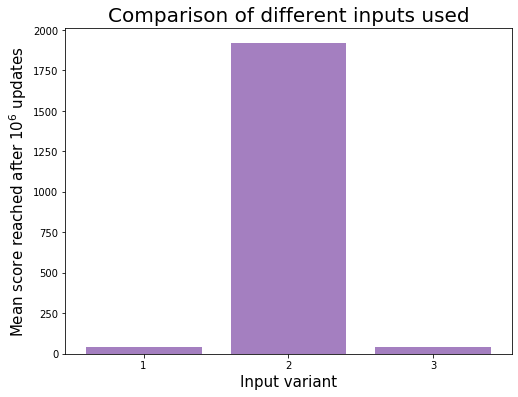

In [12]:
variant_inputs = dataQ[2]["variantInputs"]

fig = plt.figure(figsize=(8,6))
plt.bar(["1","2","3"], [np.mean(np.array(variant_inputs[f"{i}"])) for i in (1,2,3)], color="indigo", alpha=0.5)
plt.title("Comparison of different inputs used", fontsize=20)
plt.xlabel("Input variant", fontsize=15)
plt.ylabel("Mean score reached after $10^6$ updates", fontsize=15)
plt.show()

Lastly, we compare different learning rates ranging from 1 to 0.001. The learning rate of 1 does not work very well but 0.1, 0.01, and 0.001 seem to have similar behaviors. Lastly, we try out a variable learning rate in which the learning rate at tiem $t$ is determined at each update using the equation

$$ \alpha_t = \frac{1}{1 + \sum_{k=0}^t \mathbb{1}_{ \{ s_k = s_t, a_k = a_t \} }} $$

which would represent a smaller learning rate for each matrix entry each time that it is updated. However, this does not seem to work in practice and performs worse.

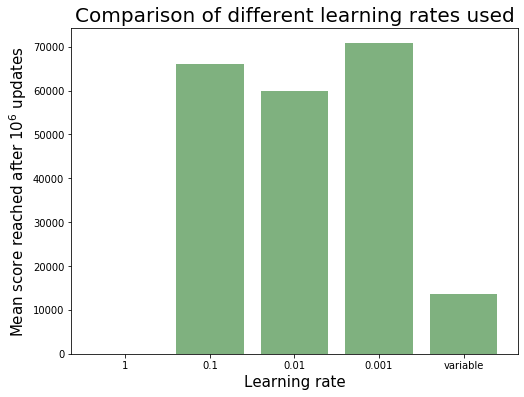

In [13]:
learning_rates = dataQ[3]["learningRate"]

fig = plt.figure(figsize=(8,6))
plt.bar(["1", "0.1", "0.01", "0.001", "variable"], [np.mean(np.array(learning_rates[x])) for x in ("1", "0.1", "0.01", "0.001", "variable")], color="#006400", alpha=0.5)
plt.title("Comparison of different learning rates used", fontsize=20)
plt.xlabel("Learning rate", fontsize=15)
plt.ylabel("Mean score reached after $10^6$ updates", fontsize=15)
plt.show()

# III. Neuroevolution

The **Neuroevolution** algorithm consists in generations of birds associated to neural networks that learn how to play the game of Flappy Bird. In each generation, $50$ birds are generated. At the end of each generation, when all 50 birds are dead, they are ranked according to their score (the best birds are those which overcame the greatest amount of obstacles). The inputs of the neural network are the $y$ position of the bird and the $y$ position of the next obstacle. In each frame, the output of the neural networks of all birds is computed. Between each dense layer, the activation function used is the sigmoid function so that the output is a value between $0$ and $1$. If it is greater than $0.5$, the bird jumps, otherwise, it continues to fall.

For the first generation of birds. The weights of their neural networks are computed uniformly between $-1$ and $1$. For the next generation of birds, we use 3 different ways to generate the neural networks of the next generation. 
- Firstly, a proportion of neural networks of the birds that had the best scores are kept for the next generation. This is called **elitism** (`elitism` in our code).
- Secondly, some birds are generated by **breeding**. This means the neural network of a new bird will be created by mixing the neural networks of a pair of parents. We can also add mutations.
- Thirdly, we also add new randomly generated networks (`randomBehaviour` in our code).

There are many other ways to generate neural networks for the next generation. For instance, we can also slightly mutate the neural network of well performing bird to create one for the next generation.

When we create mutations in a neural network, two paramters need to be defined:
- The mutation rate (`mutationRate` in our code).
- The mutation range, i.e. by how much do we change the weight when we mutate in (`mutationRange` in our code). For instance, if `mutationRange` is set to `alpha`, we add a random number between `-alpha` and `alpha` to the weight that we mutate.

To begin with, we want to set the parameters `elitism` and `randomBehaviour` in order to have a well performing algorithm. Let us study the performance of the algorithm for different sets of variables. Note that the proportion of birds created by breeding is computed as `1 - elitism - randomBehaviour`. Hence, if `elitism = 0.3` and `randomBehaviour = 0.3`, $40$% of the birds will be created by breeding for the next generation.

Let us denote
- E: elitism (`elitism`),
- R: random networks (`randomBehaviour`),
- B: Breeding.

In order to study performance of a set of parameters, we study the average number of generations needed to generate a bird that is capable of reaching a score of $100000$ (we take the average over $50$ tests). Reaching a score of $100000$ approximately corresponds to playing the game for $30$ minutes without touching a single obstacle.

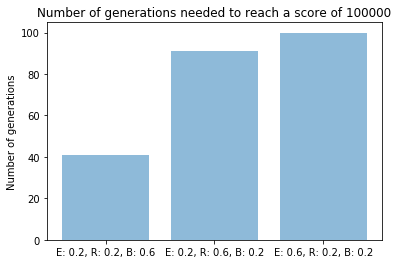

In [4]:
plt.bar(['E: 0.2, R: 0.2, B: 0.6', 'E: 0.2, R: 0.6, B: 0.2', 'E: 0.6, R: 0.2, B: 0.2'], [40.86, 91.3, 99.9], align='center', alpha=0.5)
plt.ylabel('Number of generations')
plt.title('Number of generations needed to reach a score of 100000')
plt.show()

As we can see above, setting `elitism` to $0.2$ and `randomBehaviour` to $0.2$ seem to be a good choice. This suggests that slightly mutating well performing networks to generate the next generation of birds might be a good way to get an efficient algorithm.

In order to study the impact of the other parameters, we fix `elitism = 0.2` and `randomBehaviour = 0.2` for the rest of the notebook. Hence, we construct the next generation of birds by taking the $20$% best birds of the previous generation, $20$% of the birds are genrated completely randomly and the last $60$% birds are generated by breeding (we only mutate the birds generated by breeding).

Now, let us study what is the impact of changing `mutationRate` for our neuroevolution algorithm. The parameters of our neuroevolution algorithm are the following and we study the case where `alpha` is set to $0.1, 0.3, 0.5, 0.7, 0.9$.

<img src="img/parameters.png" width="700">

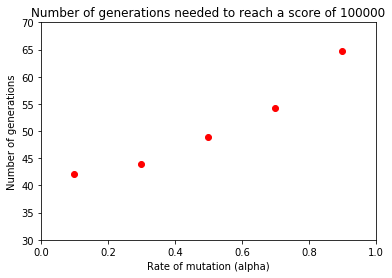

In [32]:
plt.plot([0.1, 0.3, 0.5, 0.7, 0.9], [42.16, 43.96, 48.9, 54.26, 64.78], 'ro')
plt.axis([0, 1, 30, 70])
plt.title("Number of generations needed to reach a score of 100000")
plt.xlabel("Rate of mutation (alpha)")
plt.ylabel("Number of generations")
plt.show()

As we can see above, the number of generations needed to reach a score of $100000$ increases with the mutation rate. We can deduce that birds performing well only need few mutations to perform even better.

When we do not do any mutation (when `mutationRate = 0`), it takes a very big amount of generations to reach a score of $100000$ (around $2000$). Moreover, when we do not do any mutation and generate the next generation of birds only by using the networks of the best performing birds from the previous genereation (without creating totally new birds, i.e. when `randomBehaviour = 0`, `mutationRate = 0` and `elitism = 0.2`), the algorithm seem to never be able to reach a score of $100000$. Hence, we can deduce that randomness is key for the Neuroevolution algorithm to learn to play the game of Flappy Bird. As a result, we can deduce that **randomness is key for the neuroevolution algorithm to improve**.

Now that we know that $0.1$ is a good mutation rate for our algorithm, let us study what should be the range of a mutation. To do so, let us study the case where `beta` is set to $0.1, 0.3, 0.5, 0.7, 0.9$.

<img src="img/parameters_2.png" width="700">

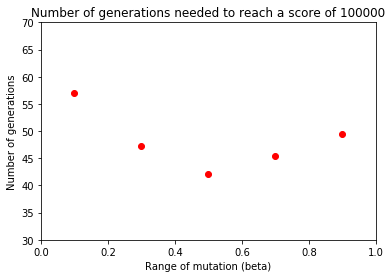

In [31]:
plt.plot([0.1, 0.3, 0.5, 0.7, 0.9], [57, 47.34, 42.16, 45.5, 49.42], 'ro')
plt.axis([0, 1, 30, 70])
plt.title('Number of generations needed to reach a score of 100000')
plt.xlabel('Range of mutation (beta)')
plt.ylabel('Number of generations')
plt.show()

As we can see in the graph above, $0.5$ seem to be a good choice for `mutationRange`. Hence, when it is decreasing this parameter decreases the rate at which our algorithm learns and incrising it lead to too big changes in the neural networks, meaning that we lose some information taht we have learnt.

From now on, let us fix `mutationRange = 0.5` and `mutationRate = 0.1`. Until now we have used a neural network cotaining a single hidden layer of 3 nides. Let us study other combinations of neural network structures. Again, we want to know the number of generations needed to reach a score of $10000$. To begin with, let us study the performance when we vary the number of hidden layers. In the graph below, all hidden layers have 3 nodes.

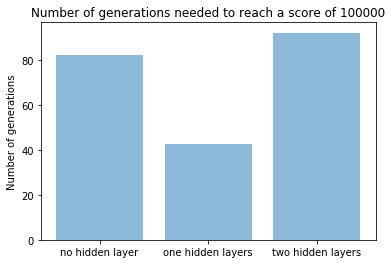

In [38]:
plt.bar(['no hidden layer', 'one hidden layers', 'two hidden layers'], [82.3, 42.6, 92.24], align='center', alpha=0.5)
plt.ylabel('Number of generations')
plt.title('Number of generations needed to reach a score of 100000')
plt.show()

As we can see above, one hidden layer seem to be the best option. Having more than one hidden layer is not a good idea since the problem we want to solve is not very complex. Having 2 hidden layers is thus useless and it increases the number of computations. The inputs of the neural network are two numbers between $0$ and $1$ and in order for the bird to overcome an obstacle, we just need these two values to be approximately equal (i.e. the bird has to be at the same height as the obstacle). Having no hidden layer is not a good idea either since our problem is not linear.

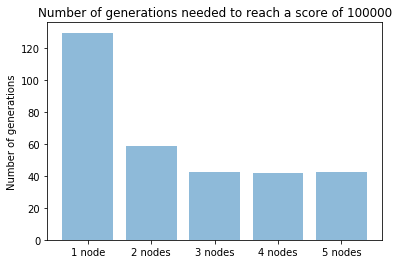

In [40]:
plt.bar(['1 node', '2 nodes', '3 nodes', '4 nodes', '5 nodes'], [129.74, 58.62, 42.6, 41.68, 42.72], align='center', alpha=0.5)
plt.ylabel('Number of generations')
plt.title('Number of generations needed to reach a score of 100000')
plt.show()

As we can see above, 3 hidden nodes seem to be the best option. In fact, $1$ or $2$ nodes in the hidden layer are not sufficient to deal with the non-linear problem. Taking more than 3 nodes is unnecessary since

# IV. Comparison of the two algorithms

- Neuroevolution requires much lower storage and memory than Q-learning which has to store big matrices, which can be a crucial factor in other places where reinforcement learning is applied.
- Neuroevolution is much faster to achieve very high scores than Q-learning.
- **Randomness** plays a very crucial role in the Neuroevolution algorithm and has a big impact on its performance. Different rates and ranges of random mutations in the neural networks can lead to very different outcomes. However, in the Q-learning, there is no randomness involved.
- Initially, the values of the neural network weights are set to random values, while in the Q matrix, we initialize everything to zero.

# V. Where can we improve?

- We can make the game harder and test the two algorithms by decreasing space between pipes and decreasing the space in between the pipes. We might need more inputs to the algorithms in this case.

# VI. Some achievements of ours

1. Implemented the game in JavaScript from scratch
2. Implemented both algorithms without the aid of any external library
3. Q-Learning was built with only the theory in mind and without looking at any other code sources

# VII. References

## Neuroevolution

1. The concept of Neuroevolution: [Scholarpedia](http://www.scholarpedia.org/article/Neuroevolution).
2. Inspiration for the structure of the entire algorithm (some code come from this repository): [xviniette's repository](https://github.com/xviniette/FlappyLearning)
3. Inspiration, similar project: [kishorliv's repository](https://github.com/kishorliv/Flappy-Bird-Neuro-evolution)

## Q-Learning:

1. Convergence of Q-learning: [Watkins and Dayan in 1992](http://www.gatsby.ucl.ac.uk/~dayan/papers/wd92.html).
2. Q-learning applied to flappy bird: [Moritz Ebeling-Rump, Manfred Kao, Zachary Hervieux-Moore](http://kilyos.ee.bilkent.edu.tr/~eee546/FlappyQ.pdf).
3. Inspiration for discretization: [Cihan Ceyhan's repository](https://github.com/chncyhn/flappybird-qlearning-bot).
4. Inspiration for restoring game states for training: [kyokin78's repository](https://github.com/kyokin78/rl-flappybird).